In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [156]:
device = "cuda" if torch.cuda.is_available else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [157]:
# Load data

df = pd.read_csv("../data/GOOGL.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602


In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4431 entries, 0 to 4430
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4431 non-null   object 
 1   Open       4431 non-null   float64
 2   High       4431 non-null   float64
 3   Low        4431 non-null   float64
 4   Close      4431 non-null   float64
 5   Adj Close  4431 non-null   float64
 6   Volume     4431 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 242.4+ KB


In [159]:
# Select columns for training

data = df[["Open", "High", "Low", "Close"]].values
data

array([[  50.050049,   52.082081,   48.028027,   50.220219],
       [  50.555557,   54.594597,   50.300301,   54.209209],
       [  55.430431,   56.796799,   54.579578,   54.754753],
       ...,
       [2722.030029, 2821.      , 2722.030029, 2797.360107],
       [2774.050049, 2791.77002 , 2756.699951, 2765.51001 ],
       [2784.      , 2832.379883, 2755.01001 , 2831.439941]])

In [160]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
scaled_data[:5]

array([[1.36253641e-04, 3.89649828e-04, 0.00000000e+00, 5.60505519e-05],
       [3.06152003e-04, 1.23277345e-03, 7.75532854e-04, 1.40975800e-03],
       [1.94456941e-03, 1.97176518e-03, 2.23606090e-03, 1.59489433e-03],
       [2.02699418e-03, 1.65601412e-03, 1.29995681e-03, 8.25473121e-04],
       [9.70602048e-04, 1.05138373e-03, 1.35291161e-03, 1.01740448e-03]])

In [161]:
# Create sequences

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 3])  # 3 = Close column index
    return np.array(X), np.array(y)

SEQ_LEN = 30
X, y = create_sequences(scaled_data, SEQ_LEN)

In [162]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [163]:
# Convert to tensors

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [164]:
# Create datasets

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [165]:
# Create dataloaders

BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [166]:
print(f"Training dataset | Size: {len(train_dataset)} | Batches: {len(train_dataloader)}")
print(f"Test dataset | Size: {len(test_dataset)} | Batches: {len(test_dataloader)}")

Training dataset | Size: 3520 | Batches: 110
Test dataset | Size: 881 | Batches: 28


In [167]:
# Model

class StockRNN(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 output_size: int):
        super(StockRNN, self).__init__()

        self.i2h = nn.Linear(in_features=input_size + hidden_size, out_features=hidden_size) # Input to hidden
        self.h2o = nn.Linear(in_features=hidden_size, out_features=output_size) # Hidden to output
        self.tanh = nn.Tanh()

    def forward(self, x):
        batch_size, seq_len, _ = x.shape # x.shape: (batch_size, seq_len, input_size)

        # Initialize hidden state
        h = torch.zeros(batch_size, self.i2h.out_features, device=x.device)

        for t in range(seq_len):
            x_t = x[:, t, :] # shape: (batch_size, input_size)
            combined = torch.cat((x_t, h), dim=1) # combine current input and previous hidden state | shape: (batch_size, input+hidden)
            h = self.tanh(self.i2h(combined))

        out = self.h2o(h)
        return out


In [207]:
model = StockRNN(input_size=X_train.shape[2],
                 hidden_size=64,
                 output_size=1).to(device)
model

StockRNN(
  (i2h): Linear(in_features=68, out_features=64, bias=True)
  (h2o): Linear(in_features=64, out_features=1, bias=True)
  (tanh): Tanh()
)

In [208]:
print(f"Parameter count: {sum(p.numel() for p in model.parameters())}")

Parameter count: 4481


In [209]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.0001)

In [210]:
def train_step():
    model.train()

    train_loss = 0.0

    for i, (X, y) in enumerate(train_dataloader):
        # Carry tensors to device
        X = X.to(device)
        y = y.to(device)

        # Forward pass
        y_preds = model(X)

        # Loss
        loss = criterion(y_preds, y)
        train_loss += loss

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Get average loss
    train_loss /= len(train_dataloader)

    return train_loss


In [211]:
def test_step():
    model.eval()

    test_loss = 0.0

    for i, (X, y) in enumerate(test_dataloader):
        # Carry tensors to device
        X = X.to(device)
        y = y.to(device)

        # Forward pass
        y_preds = model(X)

        # Loss
        loss = criterion(y_preds, y)
        test_loss += loss

    # Get average loss
    test_loss /= len(test_dataloader)

    return test_loss


In [212]:
# Initialize metrics

metrics = {}
metrics["model"] = str(model)
metrics["train_losses"] = []
metrics["test_losses"] = []

metrics

{'model': 'StockRNN(\n  (i2h): Linear(in_features=68, out_features=64, bias=True)\n  (h2o): Linear(in_features=64, out_features=1, bias=True)\n  (tanh): Tanh()\n)',
 'train_losses': [],
 'test_losses': []}

In [213]:
# Training loop

epochs = 10
epoch_print_interval = epochs / 10

for epoch in range(epochs):
    train_loss = train_step()
    test_loss = test_step()
    
    metrics["train_losses"].append(train_loss.item())
    metrics["test_losses"].append(test_loss.item())

    if epoch % epoch_print_interval == 0 or epoch == epochs-1:
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.12f} | Test Loss: {test_loss:.12f}")

Epoch: 0 | Train Loss: 0.039734743536 | Test Loss: 0.006350198761
Epoch: 1 | Train Loss: 0.001877917442 | Test Loss: 0.001132689300
Epoch: 2 | Train Loss: 0.000884644571 | Test Loss: 0.000705509738
Epoch: 3 | Train Loss: 0.000589052564 | Test Loss: 0.000491268584
Epoch: 4 | Train Loss: 0.000428274128 | Test Loss: 0.000378733355
Epoch: 5 | Train Loss: 0.000330659299 | Test Loss: 0.000293821038
Epoch: 6 | Train Loss: 0.000271011639 | Test Loss: 0.000239259840
Epoch: 7 | Train Loss: 0.000223433875 | Test Loss: 0.000203403513
Epoch: 8 | Train Loss: 0.000194234046 | Test Loss: 0.000173992070
Epoch: 9 | Train Loss: 0.000172538188 | Test Loss: 0.000151955843


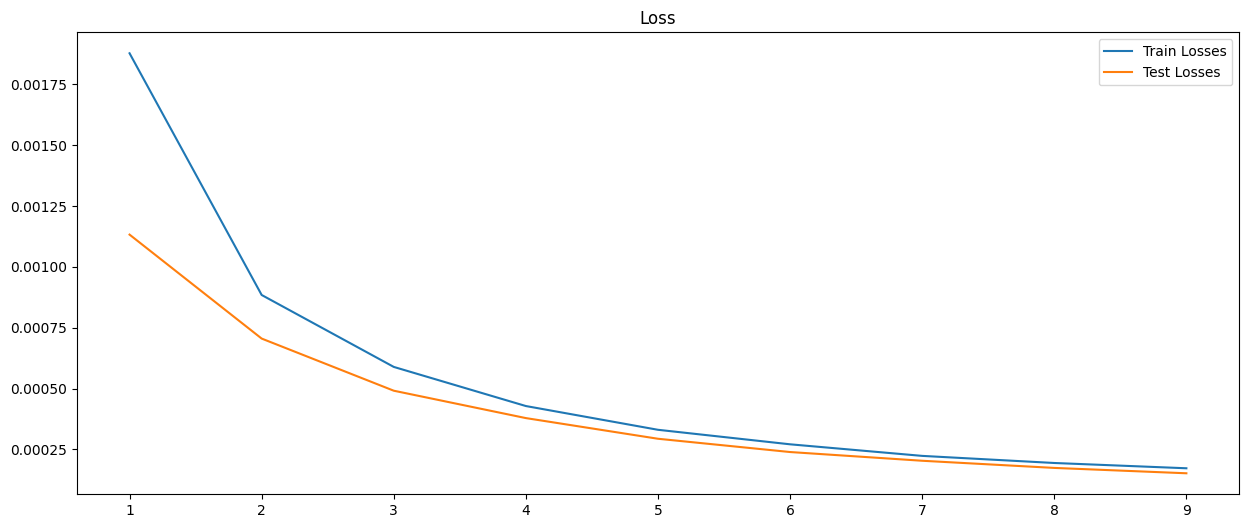

In [214]:
# We don't show the first epoch because starting loss and after convergence is hude, makes the plot harder to read

x = range(1, len(metrics["train_losses"]))

plt.figure(figsize=(15, 6))

plt.plot(x, metrics["train_losses"][1:], label="Train Losses")
plt.plot(x, metrics["test_losses"][1:], label="Test Losses")

plt.title("Loss")
plt.legend()
plt.show()